# KNN Regressor

Environment: R 3.6.1 and Jupyter notebook

Libraries used:
* dplyr
* ggplot2
* reshape2

## Introduction

In this notebook, a KNN regressor need to be implemented as a function `knn(train.data, train.label, test.data, K=3)`. 

The regressor function is `mean` and the distance function is Manhattan distance function.

As the R language is a functional language and R is slow when using for-loop, I try to use inner functions and closures with apply-family functions in the implementations instead of for-loops. 

Besides, to make the algorithms implemented suitable for more generic purpose, the generalization of machine learning algorithms is considered. Therefore, the OOP paradigm is used here.

## Import libraries

In [1]:
library(dplyr)
library(ggplot2)
library(reshape2)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [2]:
read_data <- function(fname, sc) {
  data <- read.csv(file = fname, head = TRUE, sep = ",")
  nr = dim(data)[1]
  nc = dim(data)[2]
  x = data[1:nr, 1:(nc - 1)]
  y = data[1:nr, nc]
  if (isTRUE(sc)) {
    x = scale(x)
    y = scale(y)
  }
  return(list("x" = x, "y" = y))
}

## Read data

In [3]:
# read the train and test data
train_data <- read_data("train1.csv", FALSE)
x_train <- train_data$x
y_train <- train_data$y
test_data <- read_data("test1.csv", FALSE)
x_test <- test_data$x
y_test <- test_data$y

## Implement KNN regressor

Define a sklearn-style class `KNNRegressor` to implement the knn regressor easier and more generic.

The class `KNNRegressor` contains 
- fields: 
    - `k`: The K value in KNN
    - `x_train`: The x/predictors' values of train data
    - `y_train`: The y/labels' values of train data
- methods:
    - `fit`: This method is for making the machine learning model object to fit train data. For KNNRegressor, it is recording the train data for computing nearest neighbours.
    - `predict`: This method is for making the machine learning model to predict the test data to get predicted labels.

In [4]:
KNNRegressor <- setRefClass("KNNRegressor",
                            fields = list(k = "numeric", x_train = "data.frame", y_train = "data.frame"),
                            methods = list(
                                
                              initialize = function(k) {
                                .self$k <- k
                              },

                              fit = function(x_train, y_train) {
                                .self$x_train <- x_train
                                .self$y_train <- y_train
                                .self
                              },

                              predict = function(x_test) {
                                # define a inner function for applying each row
                                predict_for_row <- function(x_test_row) {
                                  # calculate the distance for each test data
                                  distance <- .self$x_train %>% 
                                    apply(1, function(x_train_row) {
                                    # Manhattan distance function
                                    x_train_row["dist"] <- sum(abs(x_train_row - x_test_row))
                                    x_train_row
                                    }) %>% 
                                    t %>% 
                                    as.data.frame %>% .["dist"]
                                    
                                  # find the K nearest neighbours' labels
                                  nearest_indexes <- order(distance$dist)[1:k]
                                  train_labels <- .self$y_train[nearest_indexes,]
                                  # predict the test labels with the mean of nearest neighbours
                                  y_pred_row <- mean(train_labels)
                                  y_pred_row
                                }
                                
                                y_pred <- apply(x_test, 1, predict_for_row)
                                y_pred
                              }
                            )
)

Implement `knn` function to use the `KNNRegressor` to achieve the target.

In [5]:
knn <- function(train.data, train.label, test.data, K=3) {
    knn_regressor <- KNNRegressor(K)$fit(as.data.frame(train.data), as.data.frame(train.label))
    knn_regressor$predict(as.data.frame(test.data))
}

## Visualization

The train and test errors of KNN regressor with `K` = 1...30 need to be visualized.

So, implement the error function, `error_func`, and the other functions used to calculate the errors for given k-value.

In [6]:
# Mean of squared error
error_func <- function(test.pred, test.label) {
    mean((test.pred - test.label) ^ 2)
}
# calculate the errors for given K and data
cal_error_for_k <- function(k, x, y) {
    y_pred <- knn(x_train, y_train, x, k)
    error_func(y_pred, y)
}

# define the partial functions for calculating the errors for train and test data
cal_train_error <- function(k) cal_error_for_k(k, x=x_train, y=y_train)
cal_test_error <- function(k) cal_error_for_k(k, x=x_test, y=y_test)
k <- 1:30

In [7]:
# apply the function to get the errors
train_error <- sapply(k, cal_train_error)
test_error <- sapply(k, cal_test_error)
error <- data.frame(k=1:30, train = train_error, test = test_error)
# melt for visualization
error_melt <- melt(error, id="k")

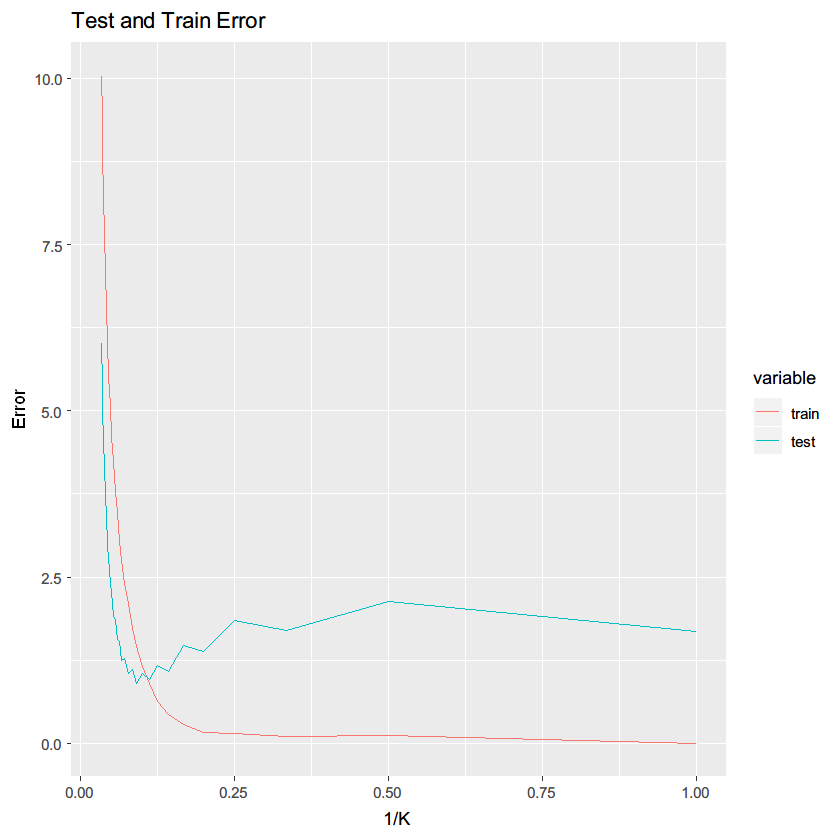

In [8]:
# plot
ggplot(data=error_melt %>% mutate(x = 1/k), aes(x=x, y=value, color=variable)) +
    geom_line() + ggtitle('Test and Train Error') + labs(x="1/K", y="Error")

In [9]:
which.min(error$test)

[1] 11

## Optimum value

From the plot visualized and the calculated K value with minimum test error, the optimized K value is `11`.

When K < 11, it is overfitting. As the predicted label is more depended on the few nearest neighbours rather than the majority data when K is small, the complexity of the model is large, so it is overfitting.

When K > 11, it is underfitting in contrast.

Therefore, when K = 11, the model is optimized.